In [1]:
# Import necessary libraries: pandas, numpy, matplotlib, and yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

# Step 1: Load the data
# Load the data from yfinance into a pandas DataFrame

tick = yf.Ticker("SPY")
end_date = datetime.now().strftime('%Y-%m-%d')
data = tick.history(start='2022-01-01',end=end_date)


# get the date for VIX to create a risk switch
risk = yf.Ticker("VIX")
end_date = datetime.now().strftime('%Y-%m-%d')
riskdata = risk.history(start='2022-01-01',end=end_date)

# Preview the data to ensure it's loaded correctly! (Hint: print it)
print(data['Close'].head())

ERROR:yfinance:$VIX: possibly delisted; no price data found  (1d 2022-01-01 -> 2024-11-06)


Date
2022-01-03 00:00:00-05:00    458.720306
2022-01-04 00:00:00-05:00    458.566711
2022-01-05 00:00:00-05:00    449.761200
2022-01-06 00:00:00-05:00    449.338715
2022-01-07 00:00:00-05:00    447.562256
Name: Close, dtype: float64


In [2]:

# Step 2: Data Cleaning
# Check for missing values in the DataFrame
data.ffill
data['null_count'] = data.isna().sum(axis=1)

riskdata.ffill
riskdata['null_count'] = riskdata.isna().sum(axis=1)

# Fill In Missing Values:
data.fillna('NaN')
riskdata.fillna('NaN')


,Open,High,Low,Close,Adj Close,Volume,null_count
Date,,,,,,,


In [3]:

# Step 3: Risk Switch
# The greatest downside to linear regression indicator isthe vulnerability to rapid price changes
# as such, this switch will be in place to halt the indicator when VIX (volatility index) is too high

def add_risk_switch_column(data, riskdata, threshold=35):
  data['HighRisk'] = riskdata['Close'] > threshold
  return data
# this will add a T/F column to the data array to tell us if risk is high and the trade signal should be null
data = add_risk_switch_column(data, riskdata)





In [4]:

# Step 4: Strategy: Linear Regression indicator

def calculate_linreg(data, window, linreg_column):

  data[linreg_column] = np.nan
  # Calculate the linear regression for the specified window
  #each row needs to pull the last window number of prices and create a new dataframe
  for current_row in range(window, len(data)):

    #making the dataframe with all the parameters required
    lindata = pd.DataFrame({'price': data['Close'].iloc[current_row - window:current_row].values})
    lindata['index'] = range(1, window+1)
    lindata['pricetime'] = lindata['price'] * lindata['index']
    lindata['sqindex'] = lindata['index'] ** 2

    #implementing the regression formlua for slope and intercept
    slope = (window * lindata['pricetime'].sum() - lindata['price'].sum() * lindata['index'].sum()) / (window * lindata['sqindex'].sum() - (lindata['index'].sum()) ** 2)

    intercept = (lindata['price'].sum() - slope * lindata['index'].sum())/window

    point = slope * (window) + intercept

    # this will put the linreg value at the given row
    data.at[current_row, linreg_column] = point
  return data
#get the linear regression values for different time frames
data = calculate_linreg(data, 40, 'st_linreg')
data = calculate_linreg(data, 120, 'lt_linreg')





In [5]:
# Step 5: signals
# now we must create signals for activity
# when the VIX column is true, the signal sohuld be NULL
# when the VIX column is false, price>st_linreg, and lt_linreg(n)>lt_linreg(n-1), generate a buy signal
# VIX = false, and lt_linreg(n)<lt_linreg(n-1) OR st_linreg(n)<stLlinreg(n-1), generate a sell signal
def generate_signals(data):
  data['Signal'] = np.nan

  for current_row in range(1, len(data)):
    #null signal
    if data['HighRisk'].iloc[current_row] == True:
      data.at[current_row, 'Signal'] = 0

    else:
      #buy signal
      if data['Close'].iloc[current_row] > data['st_linreg'].iloc[current_row] and data['lt_linreg'].iloc[current_row] > data['lt_linreg'].iloc[current_row - 1]:
        data.at[current_row, 'Signal'] = 1
      #sell signal
      elif data['st_linreg'].iloc[current_row] < data['st_linreg'].iloc[current_row - 1] or data['lt_linreg'].iloc[current_row] < data['lt_linreg'].iloc[current_row - 1]:
        data.at[current_row, 'Signal'] = -1

  return data

data = generate_signals(data)

**For the future**

<ipython-input-34-b5910c708817>:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['Daily_Return'] = data['Close'].pct_change()


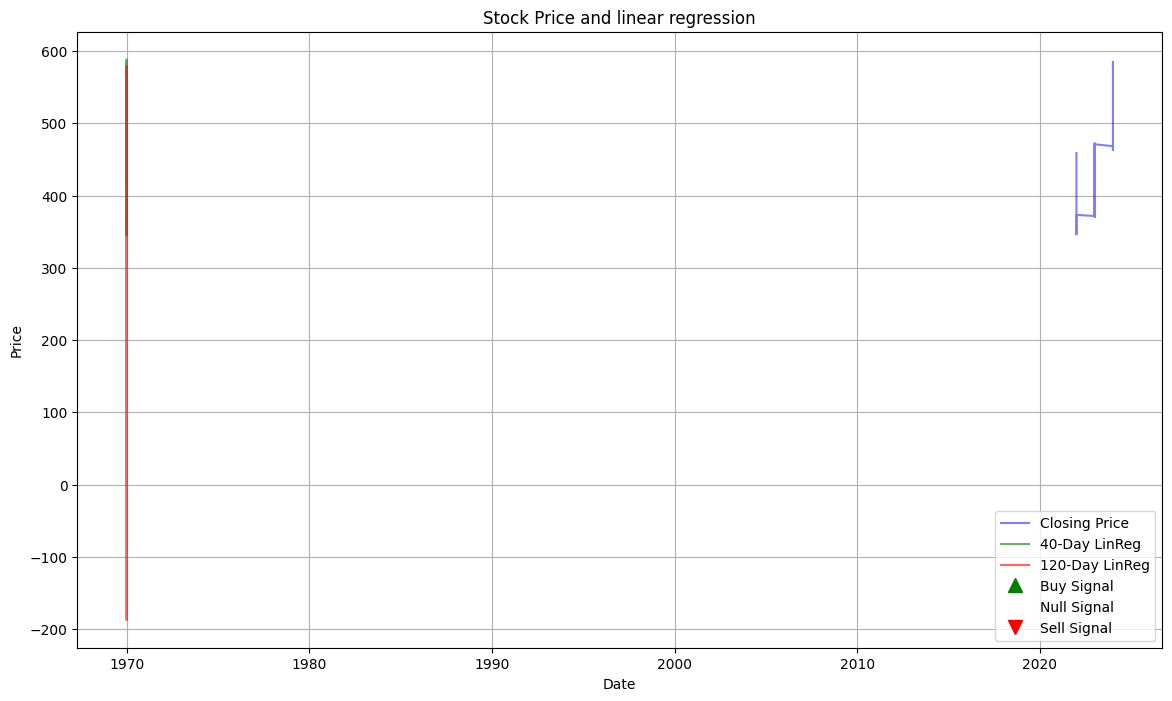

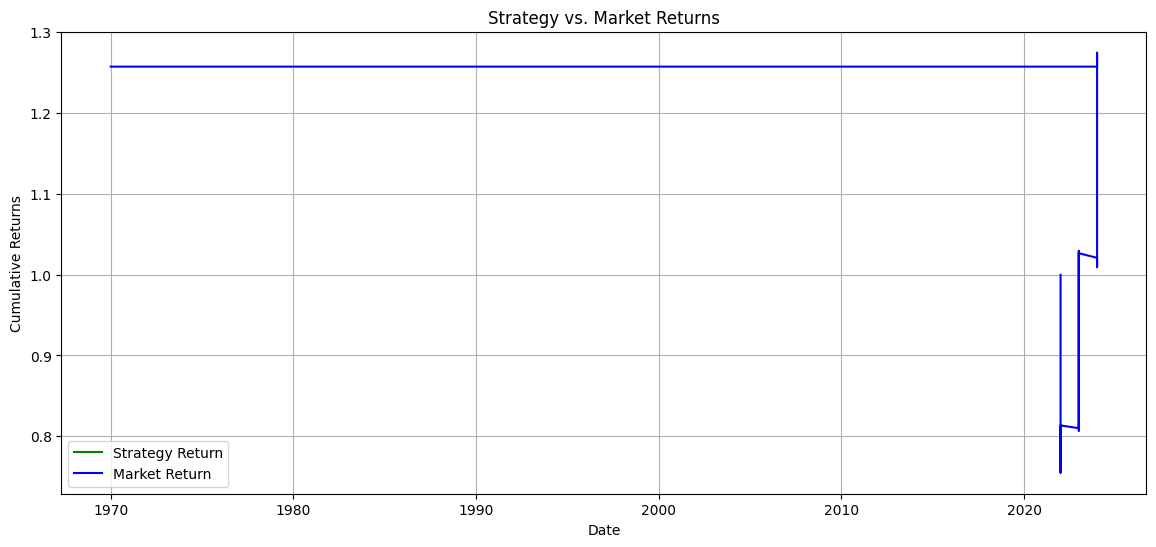

In [34]:

# Step 5: Backtesting the Strategy
# --------------------------------
# Now that we have buy and sell signals, let's simulate a basic backtesting approach.
# The goal is to see how the strategy performs by calculating returns.

def backtest_strategy(data):
    # Calculate daily returns based on the 'Close' price
    data['Daily_Return'] = data['Close'].pct_change()

    # Calculate strategy returns: if we are in a buy (1), take the return, else 0
    data['Strategy_Return'] = data['Daily_Return'] * data['Signal'].shift(1)

    # Calculate the cumulative return over the period (this gives a sense of strategy performance)
    data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

    # Similarly, calculate the cumulative return of simply holding the stock
    data['Cumulative_Market_Return'] = (1 + data['Daily_Return']).cumprod()

    return data

# Backtest the strategy
data = backtest_strategy(data)

# Step 6: Visualizing the Results
# -------------------------------
# We'll plot the stock price, the two SMAs, and the buy/sell signals, as well as strategy vs. market returns.

def plot_data(data):

    plt.figure(figsize=(14, 8))
# I have been trying to get this plotting to work, but python will not negotiate with me and refuses to graph using the current timestamps.
# Besides this, there are no real isses, and ocne this is solved it will be good to go
    d = [pd.Timestamp(x) for x in data.index]
    dates = []
    for i in range(len(d)):
        dates.append(d[i].year)

    # Plot the closing price
    plt.plot(dates, data['Close'], label='Closing Price', color='blue', alpha=0.5)

    # plot the linregs
    plt.plot(dates, data['st_linreg'], label='40-Day LinReg', color='green', alpha=0.6) # Replaced with the columns for linear regression
    plt.plot(dates, data['lt_linreg'], label='120-Day LinReg', color='red', alpha=0.6)   # Replaced with the columns for linear regression


    # Highlight buy signals
    plt.plot(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')

    # highlight null signals
    plt.plot(data.index[data['Signal'] == 0], data['Close'][data['Signal'] == 0], '-', markersize=10, color='y', lw=0, label='Null Signal')

    # Highlight sell signals
    plt.plot(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

    # Add titles and labels
    plt.title('Stock Price and linear regression')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()

# Plot the results
plot_data(data)

# Plot the cumulative returns of the strategy vs. the market
def plot_returns(data):
    plt.figure(figsize=(14, 6))
    d = [pd.Timestamp(x) for x in data.index]
    dates = []
    for i in range(len(d)):
        dates.append(d[i].year)
    # Plot cumulative returns
    plt.plot(dates, data['Cumulative_Strategy_Return'], label='Strategy Return', color='green')
    plt.plot(dates, data['Cumulative_Market_Return'], label='Market Return', color='blue')

    # Add titles and labels
    plt.title('Strategy vs. Market Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()

# Plot strategy vs market returns
plot_returns(data)

# Step 7: Conclusion
# ------------------
# This code outlines a full process from loading and cleaning the stock data to implementing an SMA-based trading strategy.
# You can adjust window sizes and further tune the strategy based on additional technical indicators or combine it with other models.